In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

Using device: cpu
Epoch 250/5000, Loss: 14.384217, PDE: 0.017721, IC: 1.421433, BC: 0.015217, Time: 84.64s
Epoch 500/5000, Loss: 14.199564, PDE: 0.047266, IC: 1.390120, BC: 0.025110, Time: 165.91s
Epoch 750/5000, Loss: 14.061934, PDE: 0.047633, IC: 1.380476, BC: 0.020954, Time: 244.37s
Epoch 1000/5000, Loss: 13.525406, PDE: 0.116284, IC: 1.302932, BC: 0.037980, Time: 324.18s
Epoch 1250/5000, Loss: 12.888967, PDE: 0.263390, IC: 1.235517, BC: 0.027040, Time: 404.79s
Epoch 1500/5000, Loss: 12.610455, PDE: 0.342061, IC: 1.201613, BC: 0.025227, Time: 482.68s
Epoch 1750/5000, Loss: 12.358929, PDE: 0.383677, IC: 1.173588, BC: 0.023937, Time: 566.15s
Epoch 2000/5000, Loss: 12.093667, PDE: 0.421941, IC: 1.140847, BC: 0.026325, Time: 646.59s
Epoch 2250/5000, Loss: 11.855909, PDE: 0.437151, IC: 1.116516, BC: 0.025360, Time: 725.10s
Epoch 2500/5000, Loss: 11.901140, PDE: 0.460192, IC: 1.118414, BC: 0.025680, Time: 808.00s
Epoch 2750/5000, Loss: 11.419696, PDE: 0.479247, IC: 1.065567, BC: 0.028478,

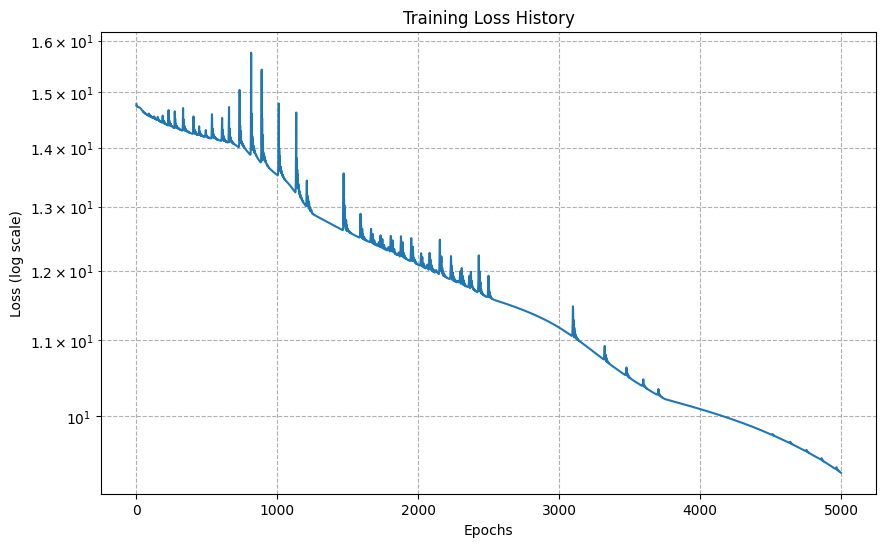

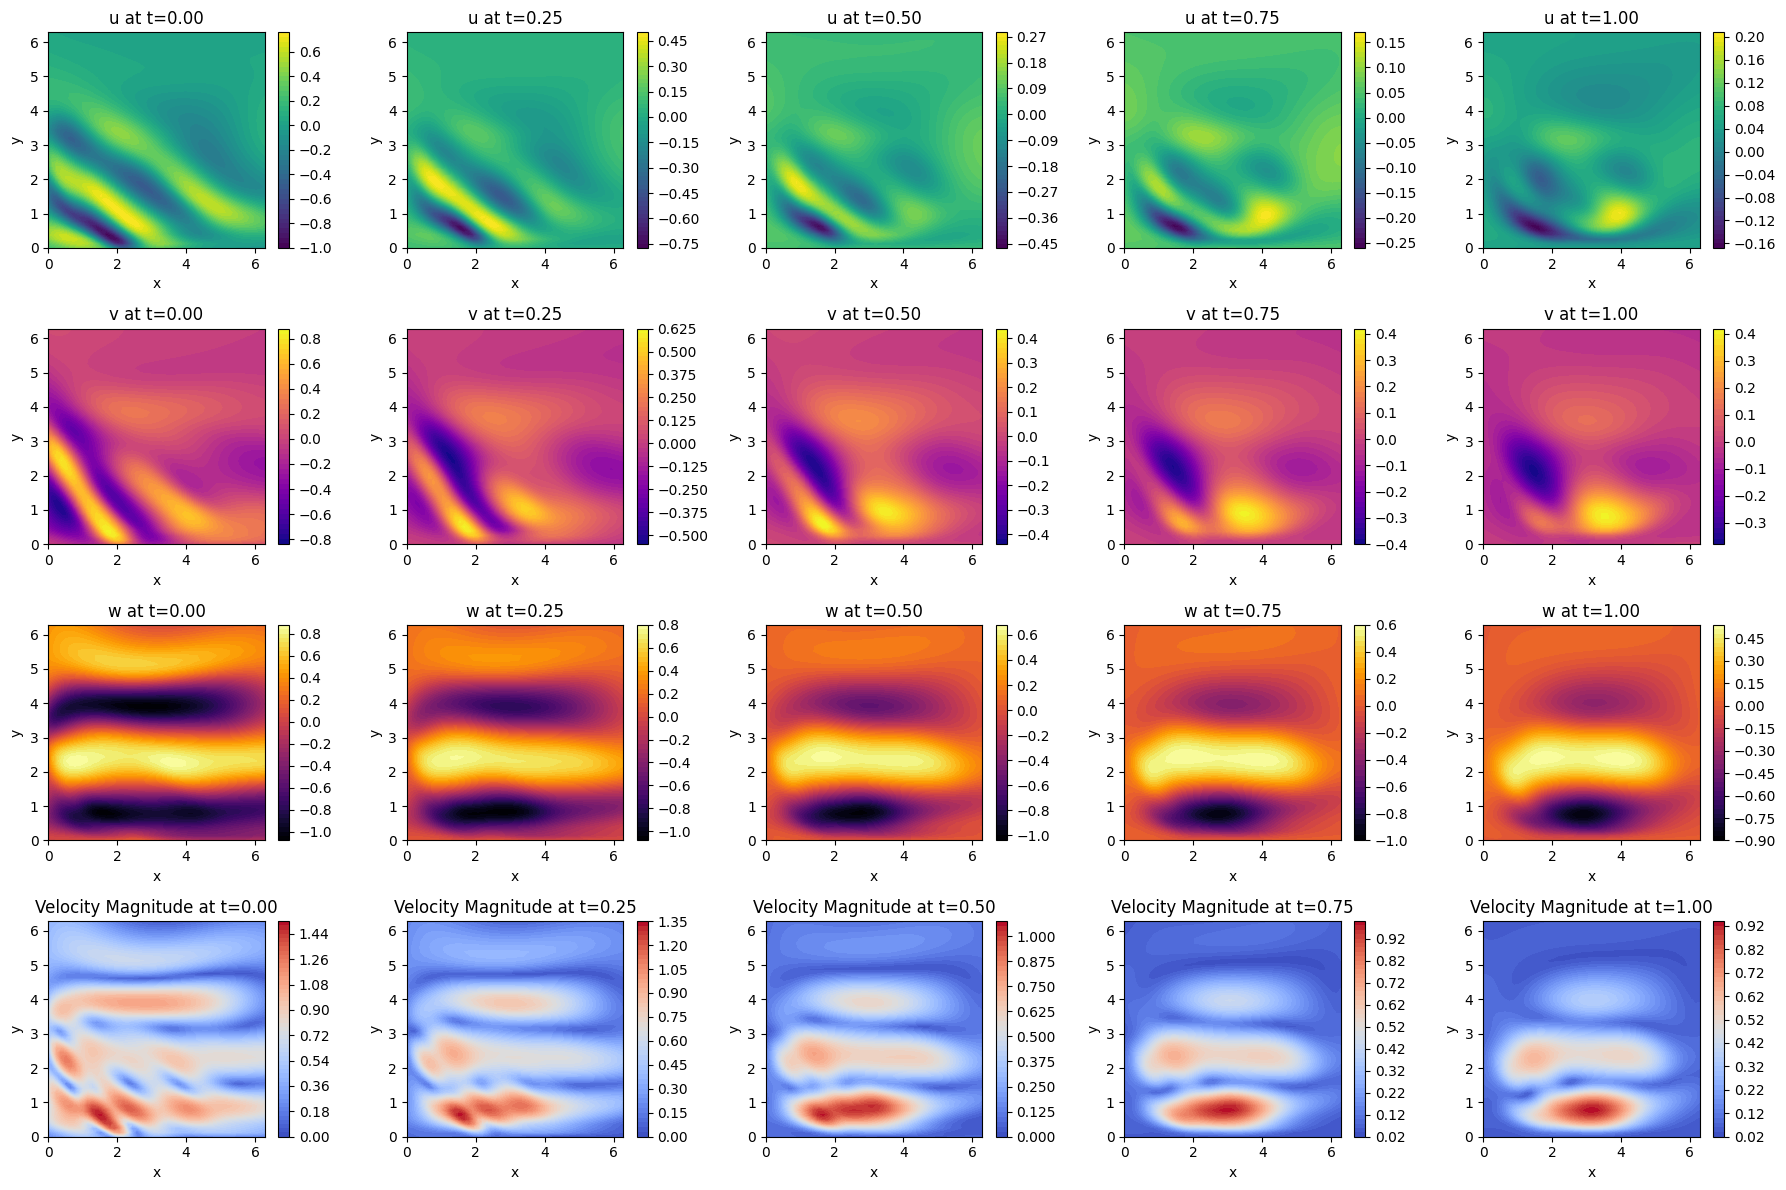

<ipython-input-2-38b6b422467d>:308: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


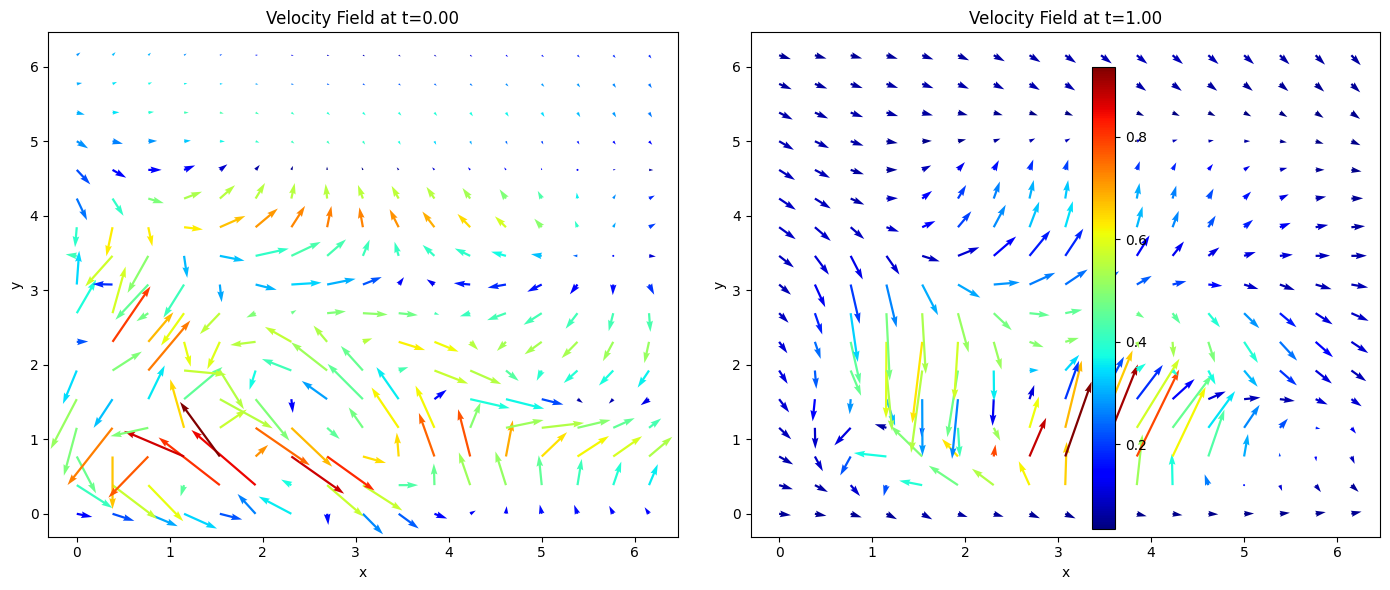

In [2]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the PINN architecture
class PINN(nn.Module):
    def __init__(self, hidden_layers, neurons_per_layer):
        super(PINN, self).__init__()

        # Input layer: (x, y, z, t) -> First hidden layer
        layers = [nn.Linear(4, neurons_per_layer), nn.Tanh()]

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())

        # Output layer: Last hidden layer -> (u, v, w)
        layers.append(nn.Linear(neurons_per_layer, 3))

        self.network = nn.Sequential(*layers)

    def forward(self, x, y, z, t):
        # Stack inputs
        inputs = torch.cat([x, y, z, t], dim=1)
        return self.network(inputs)

# Physical parameters
rho = 1.0  # Density
gamma = 1.4  # Ratio of specific heats

# Domain parameters
x_min, x_max = 0.0, 2.0 * np.pi
y_min, y_max = 0.0, 2.0 * np.pi
z_min, z_max = 0.0, 2.0 * np.pi
t_min, t_max = 0.0, 1.0  # Simulate up to t=1

# IC and BC functions
def initial_condition_u(x, y, z):
    return torch.sin(2*x + 3*y)

def initial_condition_v(x, y, z):
    return torch.cos(3*x + 2*y)

def initial_condition_w(x, y, z):
    return torch.sin(2*y + z)

# Function to create training points
def create_training_data(n_domain, n_initial, n_boundary):
    # Interior domain points (x, y, z, t)
    x_domain = torch.rand(n_domain, 1, device=device) * (x_max - x_min) + x_min
    y_domain = torch.rand(n_domain, 1, device=device) * (y_max - y_min) + y_min
    z_domain = torch.rand(n_domain, 1, device=device) * (z_max - z_min) + z_min
    t_domain = torch.rand(n_domain, 1, device=device) * (t_max - t_min) + t_min

    # Initial condition points (t=0)
    x_initial = torch.rand(n_initial, 1, device=device) * (x_max - x_min) + x_min
    y_initial = torch.rand(n_initial, 1, device=device) * (y_max - y_min) + y_min
    z_initial = torch.rand(n_initial, 1, device=device) * (z_max - z_min) + z_min
    t_initial = torch.zeros(n_initial, 1, device=device)

    # Boundary points for periodic boundary conditions
    # For x boundaries (x=0 and x=2π)
    x_boundary_left = torch.zeros(n_boundary // 6, 1, device=device)
    x_boundary_right = torch.ones(n_boundary // 6, 1, device=device) * x_max
    y_boundary_x = torch.rand(n_boundary // 3, 1, device=device) * (y_max - y_min) + y_min
    z_boundary_x = torch.rand(n_boundary // 3, 1, device=device) * (z_max - z_min) + z_min
    t_boundary_x = torch.rand(n_boundary // 3, 1, device=device) * (t_max - t_min) + t_min

    # For y boundaries (y=0 and y=2π)
    y_boundary_left = torch.zeros(n_boundary // 6, 1, device=device)
    y_boundary_right = torch.ones(n_boundary // 6, 1, device=device) * y_max
    x_boundary_y = torch.rand(n_boundary // 3, 1, device=device) * (x_max - x_min) + x_min
    z_boundary_y = torch.rand(n_boundary // 3, 1, device=device) * (z_max - z_min) + z_min
    t_boundary_y = torch.rand(n_boundary // 3, 1, device=device) * (t_max - t_min) + t_min

    # For z boundaries (z=0 and z=2π)
    z_boundary_left = torch.zeros(n_boundary // 6, 1, device=device)
    z_boundary_right = torch.ones(n_boundary // 6, 1, device=device) * z_max
    x_boundary_z = torch.rand(n_boundary // 3, 1, device=device) * (x_max - x_min) + x_min
    y_boundary_z = torch.rand(n_boundary // 3, 1, device=device) * (y_max - y_min) + y_min
    t_boundary_z = torch.rand(n_boundary // 3, 1, device=device) * (t_max - t_min) + t_min

    return {
        'domain': (x_domain, y_domain, z_domain, t_domain),
        'initial': (x_initial, y_initial, z_initial, t_initial),
        'boundary_x': (x_boundary_left, x_boundary_right, y_boundary_x, z_boundary_x, t_boundary_x),
        'boundary_y': (x_boundary_y, y_boundary_left, y_boundary_right, z_boundary_y, t_boundary_y),
        'boundary_z': (x_boundary_z, y_boundary_z, z_boundary_left, z_boundary_right, t_boundary_z)
    }

# Euler equations residuals (PINN physics loss)
def euler_equations_residuals(model, x, y, z, t):
    # Enable gradient computation
    x.requires_grad_(True)
    y.requires_grad_(True)
    z.requires_grad_(True)
    t.requires_grad_(True)

    # Forward pass through the network
    u_v_w = model(x, y, z, t)
    u, v, w = u_v_w[:, 0:1], u_v_w[:, 1:2], u_v_w[:, 2:3]

    # Calculate derivatives
    du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    dv_dt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dv_dy = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    dw_dt = torch.autograd.grad(w, t, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    dw_dz = torch.autograd.grad(w, z, grad_outputs=torch.ones_like(w), create_graph=True)[0]

    # Continuity equation: ∂ρ/∂t + ∇·(ρv) = 0
    # For simplicity in 1D, considering constant density:
    residual_continuity = du_dx + dv_dy + dw_dz

    # Momentum equation: ∂(ρu)/∂t + ∇·(ρuu) + ∂p/∂x = 0
    # Simplified for 1D:
    residual_momentum_x = du_dt + u * du_dx
    residual_momentum_y = dv_dt + v * dv_dy
    residual_momentum_z = dw_dt + w * dw_dz

    return residual_continuity, residual_momentum_x, residual_momentum_y, residual_momentum_z

# Loss function
def compute_loss(model, data, lambda_pde=1.0, lambda_ic=10.0, lambda_bc=10.0):
    # Extract data
    x_domain, y_domain, z_domain, t_domain = data['domain']
    x_initial, y_initial, z_initial, t_initial = data['initial']
    x_boundary_left, x_boundary_right, y_boundary_x, z_boundary_x, t_boundary_x = data['boundary_x']
    x_boundary_y, y_boundary_left, y_boundary_right, z_boundary_y, t_boundary_y = data['boundary_y']
    x_boundary_z, y_boundary_z, z_boundary_left, z_boundary_right, t_boundary_z = data['boundary_z']

    # PDE loss
    res_continuity, res_mom_x, res_mom_y, res_mom_z = euler_equations_residuals(model, x_domain, y_domain, z_domain, t_domain)
    loss_pde = torch.mean(res_continuity**2 + res_mom_x**2 + res_mom_y**2 + res_mom_z**2)

    # Initial condition loss
    u_v_w_pred_initial = model(x_initial, y_initial, z_initial, t_initial)
    u_initial_pred, v_initial_pred, w_initial_pred = u_v_w_pred_initial[:, 0:1], u_v_w_pred_initial[:, 1:2], u_v_w_pred_initial[:, 2:3]

    u_initial_true = initial_condition_u(x_initial, y_initial, z_initial)
    v_initial_true = initial_condition_v(x_initial, y_initial, z_initial)
    w_initial_true = initial_condition_w(x_initial, y_initial, z_initial)

    loss_ic = torch.mean((u_initial_pred - u_initial_true)**2 +
                         (v_initial_pred - v_initial_true)**2 +
                         (w_initial_pred - w_initial_true)**2)

    # Boundary condition loss (periodic)
    # x-boundaries
    u_v_w_left_x = model(x_boundary_left, y_boundary_x[:len(x_boundary_left)],
                         z_boundary_x[:len(x_boundary_left)], t_boundary_x[:len(x_boundary_left)])
    u_v_w_right_x = model(x_boundary_right, y_boundary_x[len(x_boundary_left):],
                          z_boundary_x[len(x_boundary_left):], t_boundary_x[len(x_boundary_left):])

    # y-boundaries
    u_v_w_left_y = model(x_boundary_y[:len(y_boundary_left)], y_boundary_left,
                         z_boundary_y[:len(y_boundary_left)], t_boundary_y[:len(y_boundary_left)])
    u_v_w_right_y = model(x_boundary_y[len(y_boundary_left):], y_boundary_right,
                          z_boundary_y[len(y_boundary_left):], t_boundary_y[len(y_boundary_left):])

    # z-boundaries
    u_v_w_left_z = model(x_boundary_z[:len(z_boundary_left)], y_boundary_z[:len(z_boundary_left)],
                         z_boundary_left, t_boundary_z[:len(z_boundary_left)])
    u_v_w_right_z = model(x_boundary_z[len(z_boundary_left):], y_boundary_z[len(z_boundary_left):],
                          z_boundary_right, t_boundary_z[len(z_boundary_left):])

    # Compute periodic boundary loss
    loss_bc_x = torch.mean((u_v_w_left_x - u_v_w_right_x)**2)
    loss_bc_y = torch.mean((u_v_w_left_y - u_v_w_right_y)**2)
    loss_bc_z = torch.mean((u_v_w_left_z - u_v_w_right_z)**2)
    loss_bc = loss_bc_x + loss_bc_y + loss_bc_z

    # Combine losses
    total_loss = lambda_pde * loss_pde + lambda_ic * loss_ic + lambda_bc * loss_bc

    return total_loss, loss_pde, loss_ic, loss_bc

# Training function
def train_model(model, n_domain, n_initial, n_boundary, n_epochs, learning_rate, display_interval=100):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//4, gamma=0.5)

    start_time = time.time()
    loss_history = []

    # Generate training data
    training_data = create_training_data(n_domain, n_initial, n_boundary)

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        loss, loss_pde, loss_ic, loss_bc = compute_loss(model, training_data)
        loss.backward()

        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        if (epoch + 1) % display_interval == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}, PDE: {loss_pde.item():.6f}, "
                  f"IC: {loss_ic.item():.6f}, BC: {loss_bc.item():.6f}, Time: {elapsed:.2f}s")

    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return loss_history

# Evaluation and visualization
def evaluate_model(model, resolution=50):
    # Create a mesh grid for visualization
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    z = np.linspace(z_min, z_max, resolution)
    t_eval = np.linspace(0, t_max, 5)  # Evaluate at multiple time steps

    X, Y = np.meshgrid(x, y)

    results = []

    # Fixed z for 2D visualization
    z_fixed = (z_max - z_min) / 2

    for t_val in t_eval:
        # Convert to tensors
        x_tensor = torch.tensor(X.flatten()[:, None], dtype=torch.float32, device=device)
        y_tensor = torch.tensor(Y.flatten()[:, None], dtype=torch.float32, device=device)
        z_tensor = torch.ones_like(x_tensor, device=device) * z_fixed
        t_tensor = torch.ones_like(x_tensor, device=device) * t_val

        # Predict
        with torch.no_grad():
            u_v_w = model(x_tensor, y_tensor, z_tensor, t_tensor).cpu().numpy()

        u = u_v_w[:, 0].reshape(resolution, resolution)
        v = u_v_w[:, 1].reshape(resolution, resolution)
        w = u_v_w[:, 2].reshape(resolution, resolution)

        # Calculate velocity magnitude
        velocity_magnitude = np.sqrt(u**2 + v**2 + w**2)

        results.append((t_val, u, v, w, velocity_magnitude, X, Y))

    return results

# Plot results
def plot_results(results):
    n_times = len(results)
    fig = plt.figure(figsize=(18, 12))

    # Create subplots for u, v, w components and velocity magnitude
    for i, (t_val, u, v, w, vel_mag, X, Y) in enumerate(results):
        # Plot u component
        ax1 = fig.add_subplot(4, n_times, i + 1)
        cf1 = ax1.contourf(X, Y, u, 50, cmap='viridis')
        plt.colorbar(cf1, ax=ax1)
        ax1.set_title(f'u at t={t_val:.2f}')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')

        # Plot v component
        ax2 = fig.add_subplot(4, n_times, i + 1 + n_times)
        cf2 = ax2.contourf(X, Y, v, 50, cmap='plasma')
        plt.colorbar(cf2, ax=ax2)
        ax2.set_title(f'v at t={t_val:.2f}')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')

        # Plot w component
        ax3 = fig.add_subplot(4, n_times, i + 1 + 2*n_times)
        cf3 = ax3.contourf(X, Y, w, 50, cmap='inferno')
        plt.colorbar(cf3, ax=ax3)
        ax3.set_title(f'w at t={t_val:.2f}')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')

        # Plot velocity magnitude
        ax4 = fig.add_subplot(4, n_times, i + 1 + 3*n_times)
        cf4 = ax4.contourf(X, Y, vel_mag, 50, cmap='coolwarm')
        plt.colorbar(cf4, ax=ax4)
        ax4.set_title(f'Velocity Magnitude at t={t_val:.2f}')
        ax4.set_xlabel('x')
        ax4.set_ylabel('y')

    plt.tight_layout()
    plt.savefig('euler_pinn_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional velocity vector plot for the first and last time steps
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # First time step
    t_val, u, v, w, vel_mag, X, Y = results[0]
    axs[0].quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3], vel_mag[::3, ::3], cmap='jet')
    axs[0].set_title(f'Velocity Field at t={t_val:.2f}')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')

    # Last time step
    t_val, u, v, w, vel_mag, X, Y = results[-1]
    im = axs[1].quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3], vel_mag[::3, ::3], cmap='jet')
    axs[1].set_title(f'Velocity Field at t={t_val:.2f}')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')

    fig.colorbar(im, ax=axs.ravel().tolist())
    plt.tight_layout()
    plt.savefig('euler_velocity_field.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 6))
    plt.semilogy(loss_history)
    plt.title('Training Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.grid(True, which="both", ls="--")
    plt.savefig('euler_pinn_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main function
def main():
    # PINN parameters
    hidden_layers = 6
    neurons_per_layer = 50

    # Training parameters
    n_domain = 10000
    n_initial = 2000
    n_boundary = 3000
    n_epochs = 5000
    learning_rate = 0.001
    display_interval = 250

    # Initialize model
    model = PINN(hidden_layers, neurons_per_layer).to(device)

    # Train model
    loss_history = train_model(model, n_domain, n_initial, n_boundary, n_epochs, learning_rate, display_interval)

    # Plot training loss
    plot_loss_history(loss_history)

    # Evaluate and visualize results
    results = evaluate_model(model)
    plot_results(results)

if __name__ == "__main__":
    main()